In [276]:
import jax.numpy as jnp
from jax import grad, jacfwd
from utils_v2 import KalmanFilter
from typing import Tuple
import math
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")

In [ ]:
sigma_x = 0.05
sigma_t = 0.05
N = 20
M = 40
x_values = jnp.arange(0, 1, sigma_x)
t_values = jnp.arange(0, 2, sigma_t)
v = 0.001

In [61]:
u = jnp.sin(x_values * 2 * math.pi)
f = jnp.cos(x_values * 4 * math.pi)
nu = jnp.zeros(x_values.shape)

In [62]:
u.shape, f.shape, nu.shape

((20,), (20,), (20,))

In [63]:
x_0 = jnp.expand_dims(jnp.r_[u, f, u, f, nu], axis=-1)

In [64]:
A = -2 * jnp.ones(u.shape[0])
A = jnp.diag(A)
A += jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
A /= sigma_x**2


In [65]:
B = jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
B /= 2 * sigma_x


In [66]:
INVS = jnp.linalg.inv(jnp.eye(A.shape[0]) - 0.5 * sigma_t * v * A)

In [ ]:
def new_u(
    u: jnp.ndarray, f: jnp.ndarray, prev_u: jnp.ndarray, prev_f: jnp.ndarray, v: float
) -> jnp.ndarray:
    new_u = INVS
    temp = (jnp.eye(A.shape[0]) - 0.5 * sigma_t * v * A) @ u

    temp -= sigma_t * B @ (1.5 * u**2 - 0.5 * prev_u**2)
    temp += sigma_t * (1.5 * f - 0.5 * prev_f)
    new_u @= temp
    return new_u

In [ ]:
new_u(u, f, u, f, v)

Array([ 9.0394414e-04,  1.7579484e-01,  2.2770624e-01,  1.6910070e-01,
        8.4750503e-02,  4.7221068e-02,  8.4750518e-02,  1.6910064e-01,
        2.2770168e-01,  1.7532279e-01, -4.7221057e-02, -4.4271147e-01,
       -9.4786936e-01, -1.4489338e+00, -1.8173625e+00, -1.9527792e+00,
       -1.8173623e+00, -1.4489331e+00, -9.4786382e-01, -4.4224784e-01],      dtype=float32)

In [210]:
def new_state(
    x_k: jnp.ndarray,
    __: jnp.ndarray = None,
) -> jnp.ndarray:
    start = 0
    end = u.shape[0]
    u_k = x_k[start:end]
    start += f.shape[0]
    end += f.shape[0]
    f_k = x_k[start:end]
    start += u.shape[0]
    end += u.shape[0]
    prev_u_k = x_k[start:end]
    start += f.shape[0]
    end += f.shape[0]
    prev_f_k = x_k[start:end]
    nu = x_k[end:]

    new_x = jnp.r_[new_u(u_k, prev_u_k, f_k, prev_f_k, v), f_k, u_k, f_k, nu]
    return new_x

In [211]:
new_state(x_0).shape

(100, 1)

In [ ]:
A.shape, B.shape

((20, 20), (20, 20))

In [24]:
u.shape[0]

20

In [283]:
class ExtendedKalmanFilter(KalmanFilter):
    def __init__(
        self,
        x_0: jnp.ndarray | float | int,
        f: callable,
        h: callable,
        R: jnp.ndarray,
        Q: jnp.ndarray,
        Z: jnp.ndarray,
        w_k: jnp.ndarray,
        P_0: jnp.ndarray,
        jaccobian_f: callable = None,
        jaccobian_h: callable = None,
    ) -> None:
        if not isinstance(x_0, (jnp.ndarray, float, int)):
            raise Exception(
                "The State input must be of type jnp.ndarray, float, or int"
            )
        # Expand scalar state into array if necessary
        x_0 = jnp.expand_dims(x_0, axis=-1) if type(x_0) in (int, float) else x_0
        super().__init__(x_0, None, None, None, None, R, Q, Z, w_k, P_0)
        if jaccobian_f is not None:
            self._function_f = jaccobian_f
            self._set_matrix_f = self._set_none
            self.A = self._function_f(self.x_k)

        else:
            self._set_matrix_f = self._matrix_f

        self.f = f  # Nonlinear state transition function: f(x, u)

        if jaccobian_h is not None:
            self._function_h = jaccobian_h
            self._set_matrix_h = self._set_none
            self.H = self._function_h(self.x_k)
        else:
            self._set_matrix_h = self._matrix_h

        self.h = h  # Nonlinear measurement function: h(x)

    def _derivative(
        self, f: callable, x: float | jnp.ndarray, h: float = 1e-5
    ) -> jnp.ndarray:
        """
        Compute finite-difference derivative for a scalar function.
        If x is a jnp.ndarray, assumes single element.
        """
        if isinstance(x, jnp.ndarray):
            x = x[0]
        return jnp.array((f(x + h) - f(x - h)) / (2 * h))

    def _gradient(
        self, f: callable, x: jnp.ndarray, u: jnp.ndarray = None
    ) -> jnp.ndarray:
        """
        Compute the gradient of a scalar-valued function f at x.
        Returns the gradient as a diagonal matrix.
        """
        grad_f = grad(f)
        # Wrap gradient vector as a diagonal matrix
        return grad_f(x) if u is None else grad_f(x, u)

    def _jacobian(
        self, f: callable, x: jnp.ndarray, u: jnp.ndarray = None
    ) -> jnp.ndarray:
        """
        Compute the full Jacobian of a vector-valued function f at x.
        """
        jac_F = jacfwd(f)
        return jnp.array(jac_F(x)) if u is None else jnp.array(jac_F(x, u))

    def _set_none(self, u_k: jnp.ndarray = None) -> None:
        pass

    def _matrix_f(self, u_k: jnp.ndarray) -> None:
        """
        Set the matrices A and H by choosing the appropriate differentiation method
        based on the initial state shape. Also stores the chosen function in _function.
        """
        try:
            # Check if state is scalar-like: either a float/int or a 0-dim jnp.ndarray.
            if type(self.x_k) in (float, int) or (
                type(self.x_k) is jnp.ndarray
                and jnp.array(self.x_k).squeeze().shape == ()
            ):
                self.A = self._derivative(self.f, self.x_k)
                self._function_f = self._derivative
                self._function_h = self._derivative
            # If state is a vector (1-dimensional array)
            elif self.x_k.squeeze().ndim == 1:
                self.A = self._gradient(self.f, self.x_k, u_k)
                self._function_f = self._gradient
                self._function_h = self._gradient
            # Otherwise assume state is higher-dimensional and use the Jacobian
            else:
                self.A = self._jacobian(self.f, self.x_k, u_k)
                self._function_f = self._jacobian
                self._function_h = self._jacobian
        except Exception as e:
            raise RuntimeError(f"Error in EKF defining matrix F function: {e}") from e

    def _matrix_h(self) -> None:
        """
        Set the matrices A and H by choosing the appropriate differentiation method
        based on the initial state shape. Also stores the chosen function in _function.
        """
        try:
            # Check if state is scalar-like: either a float/int or a 0-dim jnp.ndarray.
            if type(self.x_k) in (float, int) or (
                type(self.x_k) is jnp.ndarray
                and jnp.array(self.x_k).squeeze().shape == ()
            ):
                self.H = self._derivative(self.h, self.x_k)
                self._function_f = self._derivative
                self._function_h = self._derivative
            # If state is a vector (1-dimensional array)
            elif self.x_k.squeeze().ndim == 1:
                self.H = self._gradient(self.h, self.x_k)
                self._function_f = self._gradient
                self._function_h = self._gradient
            # Otherwise assume state is higher-dimensional and use the Jacobian
            else:
                self.H = self._jacobian(self.h, self.x_k)
                self._function_f = self._jacobian
                self._function_h = self._jacobian
        except Exception as e:
            raise RuntimeError(f"Error in EKF defining matrix H function: {e}") from e

    def _step_estimation(self, u_k: jnp.ndarray) -> jnp.ndarray:
        """
        Predicts the next state using the nonlinear system dynamics f and control input u_k.

        Args:
            u_k: Control input vector (m x 1)

        Returns:
            Predicted state vector (n x 1)

        Raises:
            RuntimeError: If an error occurs during the prediction.
        """

        try:
            self._set_matrix_f(u_k)
            self._set_matrix_h()
            new_x_k = self.f(self.x_k, u_k) + self.w_k
            return new_x_k
        except Exception as e:
            raise RuntimeError(f"Error in EKF step estimation:{e}") from e

    def _current_state_and_process(
        self, x_km: jnp.ndarray
    ) -> Tuple[jnp.ndarray, jnp.ndarray]:
        """
        Updates the state estimate using a measurement and the Kalman gain.

        This function recomputes the linearization matrices A and H based on the current state.

        Args:
            x_km: Noisy measurement vector (p x 1)

        Returns:
            A tuple containing:
            - Corrected state estimate (n x 1)
            - Updated error covariance matrix (n x n)

        Raises:
            RuntimeError: If an error occurs during state update.
        """
        try:
            # Recompute linearization at current state
            self.A = self._function_f(self.x_k)
            self.H = self._function_h(self.x_k)
            measurements = self.H @ x_km + self.Z
            x_k = self.x_k + self.K @ (measurements - self.H @ self.x_k)
            p_k = (jnp.eye(self.K.shape[0]) - self.K @ self.H) @ self.P
            return x_k, p_k
        except Exception as e:
            raise RuntimeError(f"Error in EKF state and process update:{e}") from e

In [262]:
def jaccobian_f(x_k: jnp.ndarray) -> jnp.ndarray:
    Fuu = (
        jnp.eye(A.shape[0])
        + 0.5 * sigma_t * v * A
        - 3 * B @ jnp.diag(x_k[: A.shape[0]].squeeze()) * sigma_t
    )
    Fuu += 0.5 * B @ jnp.diag(x_k[A.shape[0] : 2 * A.shape[0]].squeeze()) * sigma_t
    Fuu @= INVS

    eye = jnp.eye(f.shape[0])
    zero = jnp.zeros(A.shape)

    Fuf = jnp.eye(f.shape[0]) * sigma_t

    F = jnp.block([[Fuu, Fuf, zero, zero, zero], [zero, eye, zero, zero, zero], [zero, zero, eye, zero, zero], [zero, zero, zero, eye, zero], [zero, zero, zero, zero,eye]])
    return F

In [263]:
jnp.diag(x_0[: A.shape[0]].squeeze()).shape

(20, 20)

In [264]:
x_0[: A.shape[0]]

Array([[ 0.0000000e+00],
       [ 3.0901700e-01],
       [ 5.8778524e-01],
       [ 8.0901706e-01],
       [ 9.5105654e-01],
       [ 1.0000000e+00],
       [ 9.5105648e-01],
       [ 8.0901700e-01],
       [ 5.8778518e-01],
       [ 3.0901679e-01],
       [-8.7422777e-08],
       [-3.0901721e-01],
       [-5.8778554e-01],
       [-8.0901712e-01],
       [-9.5105648e-01],
       [-1.0000000e+00],
       [-9.5105648e-01],
       [-8.0901682e-01],
       [-5.8778495e-01],
       [-3.0901694e-01]], dtype=float32)

In [265]:
def h(x_k: jnp.ndarray) -> jnp.ndarray:
    return jnp.block([jnp.eye(A.shape[0]),jnp.zeros(A.shape),jnp.zeros(A.shape),jnp.zeros(A.shape),jnp.zeros(A.shape)])


In [266]:
R = jnp.eye(u.shape[0]) * 0.005

Q = jnp.eye(5 * u.shape[0]) * 0.005
mean = 0
std_dev = 0.005

P_0 = jnp.eye(5 * u.shape[0])
Z = jnp.zeros((A.shape[0],1))
w_k = jnp.zeros((5 * A.shape[0],1))


In [284]:
ekf = ExtendedKalmanFilter(x_0, new_state, h, R, Q, Z, w_k, P_0, jaccobian_f, h)

In [285]:
ekf.predict(jnp.eye(u.shape[0]))

Array([ 9.0394414e-04,  1.7579484e-01,  2.2770624e-01,  1.6910070e-01,
        8.4750503e-02,  4.7221068e-02,  8.4750518e-02,  1.6910064e-01,
        2.2770168e-01,  1.7532279e-01, -4.7221057e-02, -4.4271147e-01,
       -9.4786936e-01, -1.4489338e+00, -1.8173625e+00, -1.9527792e+00,
       -1.8173623e+00, -1.4489331e+00, -9.4786382e-01, -4.4224784e-01,
        1.0000000e+00,  8.0901700e-01,  3.0901697e-01, -3.0901715e-01,
       -8.0901706e-01, -1.0000000e+00, -8.0901676e-01, -3.0901709e-01,
        3.0901712e-01,  8.0901724e-01,  1.0000000e+00,  8.0901676e-01,
        3.0901635e-01, -3.0901745e-01, -8.0901688e-01, -1.0000000e+00,
       -8.0901682e-01, -3.0901650e-01,  3.0901775e-01,  8.0901706e-01,
        0.0000000e+00,  3.0901700e-01,  5.8778524e-01,  8.0901706e-01,
        9.5105654e-01,  1.0000000e+00,  9.5105648e-01,  8.0901700e-01,
        5.8778518e-01,  3.0901679e-01, -8.7422777e-08, -3.0901721e-01,
       -5.8778554e-01, -8.0901712e-01, -9.5105648e-01, -1.0000000e+00,
      

In [287]:
ekf.update(x_0)

Array([ 1.7664654e-03,  3.0142799e-01,  5.6011492e-01,  7.8310555e-01,
        9.5816779e-01,  1.0286007e+00,  9.5814884e-01,  7.8309619e-01,
        5.6013137e-01,  3.0144697e-01,  1.5398338e-03, -3.0910599e-01,
       -5.8915925e-01, -8.0812192e-01, -9.5139134e-01, -1.0016878e+00,
       -9.5055485e-01, -8.0886179e-01, -5.8930051e-01, -3.0816025e-01,
        9.8233563e-01,  8.8491291e-01,  5.8572084e-01, -4.9890548e-02,
       -8.8010418e-01, -1.2860788e+00, -8.7991834e-01, -4.9827754e-02,
        5.8553314e-01,  8.8471162e-01,  9.8459566e-01,  8.0990690e-01,
        3.2276058e-01, -3.1797606e-01, -8.0566764e-01, -9.8311764e-01,
       -8.1402963e-01, -3.1057265e-01,  3.2417959e-01,  8.0045056e-01,
        0.0000000e+00,  3.0901700e-01,  5.8778524e-01,  8.0901706e-01,
        9.5105654e-01,  1.0000000e+00,  9.5105648e-01,  8.0901700e-01,
        5.8778518e-01,  3.0901679e-01, -8.7422777e-08, -3.0901721e-01,
       -5.8778554e-01, -8.0901712e-01, -9.5105648e-01, -1.0000000e+00,
      

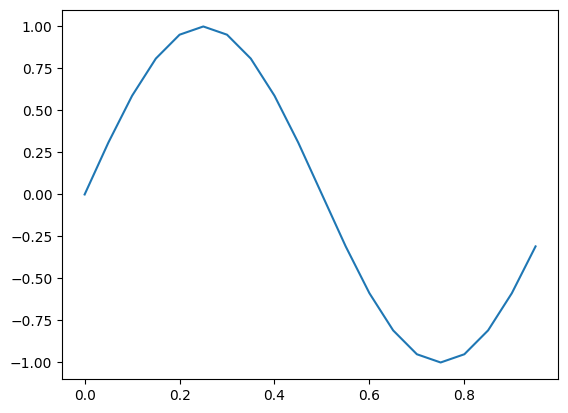

In [275]:
fig,ax=plt.subplots()
ax.plot(x_values,u)
plt.show()